# Шаг 1. Парсинг

Импортируем все нужные нам библиотеки:

In [54]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from tqdm.notebook import trange, tqdm
import time
import random
import json
from collections import defaultdict

Мы будем парсить Циан, в частности, 3-комнатные квартиры в Москве, поэтому напишем функцию, которая будет собирать соответсвующие ссылки с сайта Циана:

In [ ]:
def url_search(iterable):
    urls = []
    errors = []
    for i in tqdm(sorted(iterable, key=lambda w: random.random())):
        try:
            url = f'https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p={i}&region=1&room3=1&type=4'
            response = requests.get(url, headers={'User-Agent': UserAgent().chrome})
            soup = BeautifulSoup(response.content)
            print(response)
            for item in soup.find('div', {'data-name': 'Offers'}).find_all('a'):
                url = item.get('href')
                if url != None and 'https://www.cian.ru/rent/flat/' in url:
                    urls.append(url)
            if i in errors:
                errors.remove(i)
            time.sleep(random.randint(1, 3))
        except:
            print('error')
            errors.append(i)
    if len(errors) > 0:
        return urls.extend(url_search(errors)) 
    else:
        return urls

Применим её и получим нужные нам ссылки, которые сохраним в файл. Мы не будем парсить все 3-комнатные квартиры, а ограничимся лишь первыми 1500, которые расположены на первых 54 страницах:

In [ ]:
urls = url_search(range(1, 55))
with open('urls.json', 'w', encoding='utf8') as f:
    json.dump(urls, f)

Теперь необходимо запасрить полученные ссылки, для чего напишем функцию, которая будет собирать нужные нам данные по заданной ссылке:

Структура искомого словаря:

[стоимость, агенство недвижимости, время до ближайшего метро, общая площадь(метраж), жилая площадь(метраж), кухня(метраж), этаж, этажей в доме, год постройки, описание(текст), Холодильник(есть/нет), Посудомоечная машина(есть/нет), Стиральная машина(есть/нет), Мебель в комнатах(есть/нет), Мебель на кухне(есть/нет), Телевизор(есть/нет), Интернет(есть/нет), Кондиционер(есть/нет), Душевая кабина(есть/нет), Ванна(есть/нет), Тип ремонта(0 - не указан, 1 - без ремонта, 2 - косметический, 3 - Евро, 4 - Дизайнерский), окна на улицу(есть/нет), окна во двор(есть/нет), можно с детьми(есть/нет), можно с животными(есть/нет), адрес полный, адрес как улица + дом, район, рекомендованная цена, залог, комиссия(есть/нет), предоплата(за сколько месяцев), длительность, торг(есть/нет)]

In [ ]:
def checkurl(urlgiven):
    time.sleep(random.randint(30, 60))
    try:    
        url = urlgiven
        response = requests.get(url, headers={'User-Agent': UserAgent().chrome})

        tree = BeautifulSoup(response.content, 'html.parser')



        try:
            pricee = tree.find_all('span', {'class' : 'a10a3f92e9--price_value--1iPpd'}) #цена аренды
            strpr = pricee[0].span.get('content')[:-7].split(' ')
            k = 1
            for i in strpr[::-1]:
                price = int(i)*k
                k *= 1000
            #price
        except:
            price = 0



        agency = ''
        try:
            agenc = tree.find_all('h2', {'class' : 'a10a3f92e9--title--2gUWg'}) #ищем агенство
            agency = agenc[0].text
        except:
            agency = 'Собственник'
        #agency



        try:
            sub = tree.find_all('span', {'class' : 'a10a3f92e9--underground_time--1fKft'}) #ищем минимальное время до метро
            new = sub[0].text[4:].split(' ')
            if new[-1] == 'пешком':
                subtime = int(new[0])
            else: 
                subtime = int(new[0]) * 2 #если стоит параметр на транспорте время домножается на 2, т.к. пешком обычно в 2 раза дольше
        except:
            subtime = 0



        try:
            total = 0
            living = 0
            kitchen = 0
            floorst = 0
            floormx = 0
            built = 0
            space = tree.find_all('div', {'class' : 'a10a3f92e9--info--3XiXi'}) #тут различные характеристики площади и состояния дома
            for k in space:
                i = k.text.split('\xa0м²')
                if i[-1] == 'Общая':
                    total = int(i[0])
                if i[-1] == 'Жилая':
                    living = int(i[0])
                if i[-1] == 'Кухня':
                    kitchen = int(i[0])
                if i[-1][-1] == 'ж':
                    flor = i[0].split(' ')
                    floorst = int(flor[0])
                    floormx = int(flor[-1][:-4])
                if i[-1][-1] == 'н':
                    built = int(i[-1][:-8])
        except:
            total = 0
            living = 0
            kitchen = 0
            floorst = 0
            floormx = 0
            built = 0



        try:
            descript = tree.find_all('p', {'class' : 'a10a3f92e9--description-text--3Sal4'}) #качаем описание
            description = descript[0].text
        except:
            description = ''



        try:
            features = tree.find_all('ul', {'class' : 'a10a3f92e9--container--L-EIV'})[-1].text #тут поиск фурнитуры квартиры
            fridge = 0 
            dishwasher = 0
            washmashine = 1
            roomfurniture = 0
            kitchenfurniture = 0
            TV = 0
            net = 0
            condition = 0
            dush = 0
            vanna = 0
            if 'Холодильник' in features:
                fridge = 1
            if 'Посудомоечная машина' in features:
                dishwasher = 1
            if 'Стиральная машина' in features:
                washmashine = 1
            if 'Мебель в комнатах' in features:
                roomfurniture = 1
            if 'Мебель на кухне' in features:
                kitchenfurniture = 1
            if 'Телевизор' in features:
                TV = 1
            if 'Интернет' in features:
                net = 1
            if 'Кондиционер' in features:
                condition = 1
            if 'Душевая кабина' in features:
                dush = 1
            if 'Ванна' in features:
                vanna = 1
        except:
            fridge = 0 
            dishwasher = 0
            washmashine = 1
            roomfurniture = 0
            kitchenfurniture = 0
            TV = 0
            net = 0
            condition = 0
            dush = 0
            vanna = 0



        try:
            renovation = tree.find_all('span', {'class' : 'a10a3f92e9--value--3Ftu5'}) #тут смотрим тип ремонта и куда выходят окна
            renovationtext = ''#Тип ремонта: 0 - не указан, 1 - без ремонта, 2 - косметический, 3 - Евро, 4 - Дизайнерский
            renovationtype = 0
            streetwindow = 0
            yardwindow = 0
            for i in renovation:
                renovationtext += i.text
            if 'Без ремонта' in renovationtext:                                  
                renovationtype = 1
            if 'Косметический' in renovationtext:
                renovationtype = 2
            if 'Евроремонт' in renovationtext:
                renovationtype = 3
            if 'Дизайнерский' in renovationtext:
                renovationtype = 4
            if 'улицу' in renovationtext:
                streetwindow = 1
            if 'двор' in renovationtext:
                yardwindow = 1
        except:
            renovationtype = 0
            streetwindow = 0
            yardwindow = 0



        kids = 0
        pets = 0
        try:
            kids = tree.find_all('li', {'class' : 'a10a3f92e9--item--21VpQ a10a3f92e9--kids--3mK0H'}) #проверка на детей
            if kids[0].text == 'Можно с детьми':
                kids = 1
        except:
            kids = 0



        try:
            pets = tree.find_all('li', {'class' : 'a10a3f92e9--item--21VpQ a10a3f92e9--pets--3gLzA'}) #проверка на животных
            if pets[0].text == 'Можно с животными':
                pets = 1
        except:
            pets = 0



        fullplace = ''
        streethouse = ''
        district = ''
        try:
            place = tree.find_all('a', {'class' : 'a10a3f92e9--link--1t8n1 a10a3f92e9--address-item--1clHr'}) #ищем адрес(полный и улицу + дом отдельно + район)
            for i in place:
                fullplace += i.text
                fullplace += ' '
            streethouse = place[-2].text + ' ' + place[-1].text
            district = place[1].text
        except:
            fullplace = ''
            streethouse = ''
            district = ''



        recommendedprice = 0
        try:
            recp = tree.find_all('div', {'class' : 'a10a3f92e9--price--c1gyM'}) #смотрим рекоммендованую цену
            recop = recp[0].text.split('\xa0000\xa0₽/мес.')
            recommendedprice = int(recop[0]) * 1000
        except:
            recommendedprice = 0


        try:
            loan = tree.find_all('p', {'class' : 'a10a3f92e9--description--2xRVn'}) #тут инфа про залог, проживание и.т.д
            loanuseful = loan[0].text.split(', ')
            try:
                reallone = int(loanuseful[0].split('\xa0')[1]) * 1000 + int(loanuseful[0].split('\xa0')[2])  #залог
            except:
                reallone = 0
            try:
                if loanuseful[1] == 'без\xa0комиссии':  
                    comission = 0
                else: 
                    comission = 1
            except:    
                comission = 0
            try:
                prepay = int(loanuseful[2].split('\xa0')[-2])
            except:
                prepay = 0
            try:
                latitude = loanuseful[3].replace('\xa0', ' ') 
            except:
                latitude = 0
            try:
                if loanuseful[4] != '':
                    chaffer = 1
            except:
                chaffer = 0
        except:
            reallone = 0
            comission = 0
            prepay = 0
            latitude = 0
            chaffer = 0



        ans = [price, agency, subtime, total, living, kitchen, floorst, floormx, built, description, fridge, dishwasher, 
               washmashine, roomfurniture, kitchenfurniture, TV, net, condition, dush, vanna, renovationtype, streetwindow, 
               yardwindow, kids, pets, fullplace, streethouse, district, recommendedprice, reallone, comission, prepay, 
               latitude, chaffer]
        return({url : ans})
    
    
    
    except:
        return({url : 'Долбан, её уже удалили'})

Загрузим список нужных ссылок:

In [ ]:
with open('urls.json') as f:
    x = json.load(f)

Запарсим их:

In [ ]:
array_of_data = [ ]
errors = [ ]
los = 0
pas = 0 
for k in trange(len(x)):
    i = x[k]
    ret = checkurl(i)
    if ret == {i : 'Долбан, её уже удалили'}:
        los += 1
    else:
        pas += 1
        array_of_data.append(ret)
    print(los + pas, ' из ',  len(x), ' потерь ', los, end = '')
    print(ret)
    print('\r', end = '')
    if k % 10 == 0:
        time.sleep(random.randint(50, 250))

При пасринге периодически появляется капча, также парсинг мы проводим с разных компьютеров, поэтому необходимо очистить от капчи и объединить данные

# Очитска данных от капчи

Напишем функцию, убирающую нулевые строки в данных и возвращающую "очищенный" список данных и список убранных ссылок

In [16]:
def clear_data(array_of_data): 
    captcha = [ ]
    good_data = [ ]
    for item in array_of_data:
        for url in item:
            if item[url] == [0, 'Собственник', 0, 0, 0, 0, 0, 0, 0, '', 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '', '', '', 0, 0, 0, 0, 0, 0]:
                captcha.append(url)
            else:
                good_data.append(item)
    return good_data, captcha

Используем её для собранных данных и сохраним полученный результат

In [6]:
good_data = clear_data(array_of_data)[0]
captcha = clear_data(array_of_data)[1]

In [7]:
with open("Anton_data_1.json", 'w', encoding='utf-8') as f:
    json.dump(array_of_data, f, ensure_ascii=False, indent=4)

Мы парсили в 10 сессий, поэтому последний этап выполнялся 10 раз

# Объединение данных

Откроем все собранные данные и объеденим их в один итоговый словарь, а также найдём ссылки, которые не удалось обработать

In [9]:
data = [ ] # изначальные данные
filtered_data = [ ] # очищенные от капчи данные
captcha = [ ] # ссылки, которые не удалось обработать из-за капчи
urls_done = set( ) # ссылки, которые удалось обработать
final_data = { } # объединённые данные
# извлечение 'грязных' данных из файлов
with open("data\Anton_data_1.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Anton_data_2.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Anton_data_3.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Luka_data_1.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Luka_data_2.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Luka_data_3.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Luka_data_4.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Luka_data_5.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Luka_data_6.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open("data\Julia_data_1.json", 'r', encoding='utf-8') as f:
    data.append(json.load(f))
# 'очистка' и объединение данных
for item in data:
    filtered_data.extend(clear_data(item)[0])
    captcha.extend(clear_data(item)[1])
# получение финального словаря
for item in filtered_data:
    for key in item:
        final_data[key] = item[key] 
# убираем из капчи ссылки, котороые обработали
urls_done = set(final_data.keys())
captcha = set(captcha)
captcha = captcha - urls_done
captcha = list(captcha)
# сохранение данных
with open('data\data_combined.json', 'w', encoding='utf8') as f:
    json.dump(final_data, f, ensure_ascii=False, indent=4)

In [10]:
# поиск оставшихся ссылок
with open('urls.json', 'r') as f:
    all_urls = set(json.load(f))
unfinished_urls = all_urls - urls_done
with open('unfinished_urls.json', 'w', encoding='utf8') as f:
    json.dump(list(unfinished_urls), f)

In [11]:
unfinished_urls # оставшиеся ссылки

{'https://www.cian.ru/rent/flat/257121750/',
 'https://www.cian.ru/rent/flat/257803987/',
 'https://www.cian.ru/rent/flat/257915650/'}

Проверяя данные ссылки в ручную, получим, что все эти объявления уже удалены с Циана.

In [14]:
len(final_data.keys())

1496

Итого мы обработали 1496 ссылок и объединили их в один словарь

# Шаг 2. Предварительная обработка

1. Сначала мы создали DataFrame на основе полученных данных:

In [165]:
import pandas as pd
import json


y = []
with open("data\data_combined.json", 'r', encoding='utf-8') as f:
    y = json.load(f)

df = pd.DataFrame(y)
df = df.T
 
df.columns = ['Цена аренды', 'Агенство недвижимости', 'Минимальное время до метро, мин', 'Общая площадь,  м²', 'Жилая площадь,  м²', 'Площадь кухни,  м²', 'Этаж квартиры', 'Этажей в доме', "Год постройки", "Описание", "Холодильник", "Посудомоечная машина", "Стиральная машина", "Мебель в комнатах", "Мебель на кухне", "Телевизор", "Интернет", "Кондиционер", "Душевая кабина", "Ванна", "Тип ремонта", "Окна на улицу", "Окна во двор", "Можно с детьми", "Можно с животными", "Полный адрес", "Улица", "Район", "Рекомендованная цена", "Залог", "Комиссия", "Предоплата(за сколько месяцев)", "Длительность съёма", "Возможность торга"]
df = df.reindex(columns = ['Агенство недвижимости', 'Цена аренды','Описание',
       'Минимальное время до метро, мин', 'Общая площадь,  м²',
       'Жилая площадь,  м²', 'Площадь кухни,  м²', 'Этаж квартиры',
       'Этажей в доме', 'Год постройки', 'Холодильник', 'Посудомоечная машина', 'Стиральная машина',
       'Мебель в комнатах',  'Мебель на кухне', 'Телевизор', 'Интернет', 'Кондиционер',
       'Душевая кабина', 'Ванна', 'Тип ремонта', 'Окна на улицу', 'Окна во двор', 'Можно с детьми',
       'Можно с животными', 'Полный адрес', 'Улица', 'Район',
       'Рекомендованная цена', 'Залог', 'Комиссия', 'Предоплата(за сколько месяцев)',
       'Длительность съёма', 'Возможность торга'])
df = df.drop(columns=['Стиральная машина'])

df.head().style.hide_index()

Агенство недвижимости,Цена аренды,Описание,"Минимальное время до метро, мин","Общая площадь, м²","Жилая площадь, м²","Площадь кухни, м²",Этаж квартиры,Этажей в доме,Год постройки,Холодильник,Посудомоечная машина,Мебель в комнатах,Мебель на кухне,Телевизор,Интернет,Кондиционер,Душевая кабина,Ванна,Тип ремонта,Окна на улицу,Окна во двор,Можно с детьми,Можно с животными,Полный адрес,Улица,Район,Рекомендованная цена,Залог,Комиссия,Предоплата(за сколько месяцев),Длительность съёма,Возможность торга
Собственник,150000,"Сдается в длительную аренду трехкомнатная квартира от собственника. Тихий зеленый район, развитая инфраструктура: в доме частный детский сад, в шаговой доступности школы (частная, общеобразовательная, университетская при МПГУ), аптеки, салоны красоты, в 3 минутах пешком (610 метров) ТЦ Авиапарк. Охраняемый ЖК, подземный паркинг (одно просторное машиноместо входит в стоимость аренды). 12 минут пешком до м. ЦСКА, 20 минут пешком до м. Аэропорт. Три комнаты: спальня с гардеробной, кабинет/детская, гостиная, совмещенная с кухней. Два санузла: туалет с раковиной в малом санузле и просторная душевая, туалет и раковина в основном. Две просторных лоджии: с выходом из кухни и из спальни. Современное оборудование: кондиционеры и ЖК телевизоры во всех комнатах, на кухне индукционная плита, свч /духовая печь, посудомоечная машина, стиральная машина.",8,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,4,1,1,1,0,Москва САО р-н Хорошевский ул. Авиаконструктора Микояна 14к2,ул. Авиаконструктора Микояна 14к2,САО,217000,150000,0,1,от года,0
ELEVEN REALTY,160000,Вашему вниманию предлагается квартира расположенная в доме Булдакова. Окна выходят в тихий двор. В квартире имеется вся необходимая мебель и бытовая техника для комфортного проживания. Рассмотрим делительную аренду.,5,130,80,20,4,5,1903,1,1,1,1,1,1,1,0,1,4,0,1,1,1,Москва ЦАО р-н Пресненский Большая Садовая ул. 10,Большая Садовая ул. 10,ЦАО,316000,160000,0,1,от года,0
Вероника Кудашова,160000,"ЖК Шуваловский. Сдам элегантную трехкомнатную квартиру - мастер-спальня с выходом на лоджию, детская с гардеробной, два санузла, большая гардеробная, кухня-столовая-гостиная с панорамным окном. В спальнях минимум мебели, кровати уже привезли. Кухня-гостиная с мебелью и техникой. Охраняемая территория, паркинг, детская площадка во дворе. Богатая инфраструктура района.",3,110,60,14,6,15,2008,1,1,1,1,1,1,1,0,1,4,1,1,1,0,Москва ЗАО р-н Раменки Мичуринский просп. 3,Мичуринский просп. 3,ЗАО,196000,160000,0,1,от года,0
ID 13539540,160000,"Предлагается в аренду большая, светлая трехкомнатная квартира с высокими потолками и дизайнерским ремонтом. Планировка квартиры включает в себя: гостиную, совмещенную с кухней, две изолированные спальни, в каждой из которых есть оборудованная гардеробная комната. Два санузла. В одном санузле ванна, в другом - душевая кабина. При необходимости, мебель покупается под клиента.",15,150,110,30,3,6,1954,1,1,0,1,0,1,1,1,1,4,1,1,1,0,Москва ЮЗАО р-н Академический ул. Кржижановского 23К5,ул. Кржижановского 23К5,ЮЗАО,188000,160000,0,1,от года,0
Собственник,160000,"Предлагается в аренду трехкомнатная квартира в элитном ЖК ""МОСФИЛЬМОВСКАЯ"". Замечательные видовые характеристики и функциональная планировка. Квартира оснащена всей необходимой техникой.Качественный ремонт. Машино-место на подземном паркинге входит в стоимость. СОБСТВЕННИК",10,105,0,0,15,29,2017,1,1,1,1,1,1,1,1,0,3,1,1,1,0,Москва ЗАО р-н Раменки Мосфильмовская ул. 74Б,Мосфильмовская ул. 74Б,ЗАО,212000,0,0,2,от года,0


Итого получили следующие колонки:

In [166]:
df.columns

Index(['Агенство недвижимости', 'Цена аренды', 'Описание',
       'Минимальное время до метро, мин', 'Общая площадь,  м²',
       'Жилая площадь,  м²', 'Площадь кухни,  м²', 'Этаж квартиры',
       'Этажей в доме', 'Год постройки', 'Холодильник', 'Посудомоечная машина',
       'Мебель в комнатах', 'Мебель на кухне', 'Телевизор', 'Интернет',
       'Кондиционер', 'Душевая кабина', 'Ванна', 'Тип ремонта',
       'Окна на улицу', 'Окна во двор', 'Можно с детьми', 'Можно с животными',
       'Полный адрес', 'Улица', 'Район', 'Рекомендованная цена', 'Залог',
       'Комиссия', 'Предоплата(за сколько месяцев)', 'Длительность съёма',
       'Возможность торга'],
      dtype='object')

2. Затем составили таблицу, в которой рассмотрели, сколько 0 мы получили по каждому из признаков в процентном соотношении:

In [167]:
df[df == 0].count(axis=0)/df.shape[0] * 100

Агенство недвижимости               0.000000
Цена аренды                         0.000000
Описание                            0.000000
Минимальное время до метро, мин     8.689840
Общая площадь,  м²                  9.090909
Жилая площадь,  м²                 32.620321
Площадь кухни,  м²                 34.491979
Этаж квартиры                       9.090909
Этажей в доме                       9.090909
Год постройки                      48.529412
Холодильник                        11.831551
Посудомоечная машина               28.877005
Мебель в комнатах                  15.574866
Мебель на кухне                    11.363636
Телевизор                          19.585561
Интернет                           18.783422
Кондиционер                        35.895722
Душевая кабина                     54.077540
Ванна                              32.687166
Тип ремонта                        10.561497
Окна на улицу                      50.735294
Окна во двор                       33.622995
Можно с де

Очевидно, что по некоторым признакам их совсем нет. А по некоторым признакам 0 может означать отсутствие какой-либо возможности или запрет. Мы решили исходить из того, что если что-то прямо не разрешено в объявлении и, как следствие, не указано в нём, то оно именно отсутсвует или запрещено. Поэтому 0 в столбцах "Возможность торга", "Предоплата", "Комиссия", "Залог", "Рекомендованная цена" мы пометили как "Отсутствует". А в столбцах "Можно с детьми" и "Можно с животными" 0 - это "Нет"

In [168]:
df.loc[df['Рекомендованная цена']== 0, 'Рекомендованная цена'] = 'Отсутствует'
df.loc[df['Залог']== 0, 'Залог'] = 'Отсутствует'
df.loc[df['Комиссия']== 0, 'Комиссия'] = 'Отсутствует'
df.loc[df['Длительность съёма']== 0, 'Длительность съёма'] = 'Отсутствует'
df.loc[df['Предоплата(за сколько месяцев)']== 0, 'Предоплата(за сколько месяцев)'] = 'Отсутствует'
df.loc[df['Возможность торга']== 0, 'Возможность торга'] = 'Отсутствует'
df.loc[df['Можно с животными']== 0, 'Можно с животными'] = 'Нет'
df.loc[df['Можно с животными']== 1, 'Можно с животными'] = 'Да'
df.loc[df['Можно с детьми']== 0, 'Можно с детьми'] = 'Нет'
df.loc[df['Можно с детьми']== 1, 'Можно с детьми'] = 'Да'
df.loc[df['Тип ремонта']== 0, 'Тип ремонта'] = 'Не указан'
df.loc[df['Тип ремонта']== 1, 'Тип ремонта'] = 'Без ремонта'
df.loc[df['Тип ремонта']== 2, 'Тип ремонта'] = 'Косметический'
df.loc[df['Тип ремонта']== 3, 'Тип ремонта'] = 'Евроремонт'
df.loc[df['Тип ремонта']== 4, 'Тип ремонта'] = 'Дизайнерский'
df.loc[df['Окна на улицу']== 0, 'Окна на улицу'] = 'Нет'
df.loc[df['Окна на улицу']== 1, 'Окна на улицу'] = 'Да'
df.loc[df['Окна во двор']== 0, 'Окна во двор'] = 'Нет'
df.loc[df['Окна во двор']== 1, 'Окна во двор'] = 'Да'

In [169]:
df.head().style.hide_index()

Агенство недвижимости,Цена аренды,Описание,"Минимальное время до метро, мин","Общая площадь, м²","Жилая площадь, м²","Площадь кухни, м²",Этаж квартиры,Этажей в доме,Год постройки,Холодильник,Посудомоечная машина,Мебель в комнатах,Мебель на кухне,Телевизор,Интернет,Кондиционер,Душевая кабина,Ванна,Тип ремонта,Окна на улицу,Окна во двор,Можно с детьми,Можно с животными,Полный адрес,Улица,Район,Рекомендованная цена,Залог,Комиссия,Предоплата(за сколько месяцев),Длительность съёма,Возможность торга
Собственник,150000,"Сдается в длительную аренду трехкомнатная квартира от собственника. Тихий зеленый район, развитая инфраструктура: в доме частный детский сад, в шаговой доступности школы (частная, общеобразовательная, университетская при МПГУ), аптеки, салоны красоты, в 3 минутах пешком (610 метров) ТЦ Авиапарк. Охраняемый ЖК, подземный паркинг (одно просторное машиноместо входит в стоимость аренды). 12 минут пешком до м. ЦСКА, 20 минут пешком до м. Аэропорт. Три комнаты: спальня с гардеробной, кабинет/детская, гостиная, совмещенная с кухней. Два санузла: туалет с раковиной в малом санузле и просторная душевая, туалет и раковина в основном. Две просторных лоджии: с выходом из кухни и из спальни. Современное оборудование: кондиционеры и ЖК телевизоры во всех комнатах, на кухне индукционная плита, свч /духовая печь, посудомоечная машина, стиральная машина.",8,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,Дизайнерский,Да,Да,Да,Нет,Москва САО р-н Хорошевский ул. Авиаконструктора Микояна 14к2,ул. Авиаконструктора Микояна 14к2,САО,217000,150000,Отсутствует,1,от года,Отсутствует
ELEVEN REALTY,160000,Вашему вниманию предлагается квартира расположенная в доме Булдакова. Окна выходят в тихий двор. В квартире имеется вся необходимая мебель и бытовая техника для комфортного проживания. Рассмотрим делительную аренду.,5,130,80,20,4,5,1903,1,1,1,1,1,1,1,0,1,Дизайнерский,Нет,Да,Да,Да,Москва ЦАО р-н Пресненский Большая Садовая ул. 10,Большая Садовая ул. 10,ЦАО,316000,160000,Отсутствует,1,от года,Отсутствует
Вероника Кудашова,160000,"ЖК Шуваловский. Сдам элегантную трехкомнатную квартиру - мастер-спальня с выходом на лоджию, детская с гардеробной, два санузла, большая гардеробная, кухня-столовая-гостиная с панорамным окном. В спальнях минимум мебели, кровати уже привезли. Кухня-гостиная с мебелью и техникой. Охраняемая территория, паркинг, детская площадка во дворе. Богатая инфраструктура района.",3,110,60,14,6,15,2008,1,1,1,1,1,1,1,0,1,Дизайнерский,Да,Да,Да,Нет,Москва ЗАО р-н Раменки Мичуринский просп. 3,Мичуринский просп. 3,ЗАО,196000,160000,Отсутствует,1,от года,Отсутствует
ID 13539540,160000,"Предлагается в аренду большая, светлая трехкомнатная квартира с высокими потолками и дизайнерским ремонтом. Планировка квартиры включает в себя: гостиную, совмещенную с кухней, две изолированные спальни, в каждой из которых есть оборудованная гардеробная комната. Два санузла. В одном санузле ванна, в другом - душевая кабина. При необходимости, мебель покупается под клиента.",15,150,110,30,3,6,1954,1,1,0,1,0,1,1,1,1,Дизайнерский,Да,Да,Да,Нет,Москва ЮЗАО р-н Академический ул. Кржижановского 23К5,ул. Кржижановского 23К5,ЮЗАО,188000,160000,Отсутствует,1,от года,Отсутствует
Собственник,160000,"Предлагается в аренду трехкомнатная квартира в элитном ЖК ""МОСФИЛЬМОВСКАЯ"". Замечательные видовые характеристики и функциональная планировка. Квартира оснащена всей необходимой техникой.Качественный ремонт. Машино-место на подземном паркинге входит в стоимость. СОБСТВЕННИК",10,105,0,0,15,29,2017,1,1,1,1,1,1,1,1,0,Евроремонт,Да,Да,Да,Нет,Москва ЗАО р-н Раменки Мосфильмовская ул. 74Б,Мосфильмовская ул. 74Б,ЗАО,212000,Отсутствует,Отсутствует,2,от года,Отсутствует


Что до остальных пропусков, то нигде они не превышают 50%, а значит у нас остаётся более 500 строк с этими признаками непропущенными. Мы решили их оставить и обозначить нули как "Нет данных", потому что очевидно, что для проверки большинства возможных гипотез не понадобится смотреть на все столбцы. Следовательно, можно выдвигать и проверять гипотезы, рассматривая только строки с данными, комбинируя некоторые части таблицы и игнорируя остальные.

In [170]:
for elem in list(df.columns):
    df.loc[df[elem]==0, elem] = 'Нет данных'
df.head().style.hide_index()


Агенство недвижимости,Цена аренды,Описание,"Минимальное время до метро, мин","Общая площадь, м²","Жилая площадь, м²","Площадь кухни, м²",Этаж квартиры,Этажей в доме,Год постройки,Холодильник,Посудомоечная машина,Мебель в комнатах,Мебель на кухне,Телевизор,Интернет,Кондиционер,Душевая кабина,Ванна,Тип ремонта,Окна на улицу,Окна во двор,Можно с детьми,Можно с животными,Полный адрес,Улица,Район,Рекомендованная цена,Залог,Комиссия,Предоплата(за сколько месяцев),Длительность съёма,Возможность торга
Собственник,150000,"Сдается в длительную аренду трехкомнатная квартира от собственника. Тихий зеленый район, развитая инфраструктура: в доме частный детский сад, в шаговой доступности школы (частная, общеобразовательная, университетская при МПГУ), аптеки, салоны красоты, в 3 минутах пешком (610 метров) ТЦ Авиапарк. Охраняемый ЖК, подземный паркинг (одно просторное машиноместо входит в стоимость аренды). 12 минут пешком до м. ЦСКА, 20 минут пешком до м. Аэропорт. Три комнаты: спальня с гардеробной, кабинет/детская, гостиная, совмещенная с кухней. Два санузла: туалет с раковиной в малом санузле и просторная душевая, туалет и раковина в основном. Две просторных лоджии: с выходом из кухни и из спальни. Современное оборудование: кондиционеры и ЖК телевизоры во всех комнатах, на кухне индукционная плита, свч /духовая печь, посудомоечная машина, стиральная машина.",8,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,1,1,1,1,1,1,1,1,Нет данных,Дизайнерский,Да,Да,Да,Нет,Москва САО р-н Хорошевский ул. Авиаконструктора Микояна 14к2,ул. Авиаконструктора Микояна 14к2,САО,217000,150000,Отсутствует,1,от года,Отсутствует
ELEVEN REALTY,160000,Вашему вниманию предлагается квартира расположенная в доме Булдакова. Окна выходят в тихий двор. В квартире имеется вся необходимая мебель и бытовая техника для комфортного проживания. Рассмотрим делительную аренду.,5,130,80,20,4,5,1903,1,1,1,1,1,1,1,Нет данных,1,Дизайнерский,Нет,Да,Да,Да,Москва ЦАО р-н Пресненский Большая Садовая ул. 10,Большая Садовая ул. 10,ЦАО,316000,160000,Отсутствует,1,от года,Отсутствует
Вероника Кудашова,160000,"ЖК Шуваловский. Сдам элегантную трехкомнатную квартиру - мастер-спальня с выходом на лоджию, детская с гардеробной, два санузла, большая гардеробная, кухня-столовая-гостиная с панорамным окном. В спальнях минимум мебели, кровати уже привезли. Кухня-гостиная с мебелью и техникой. Охраняемая территория, паркинг, детская площадка во дворе. Богатая инфраструктура района.",3,110,60,14,6,15,2008,1,1,1,1,1,1,1,Нет данных,1,Дизайнерский,Да,Да,Да,Нет,Москва ЗАО р-н Раменки Мичуринский просп. 3,Мичуринский просп. 3,ЗАО,196000,160000,Отсутствует,1,от года,Отсутствует
ID 13539540,160000,"Предлагается в аренду большая, светлая трехкомнатная квартира с высокими потолками и дизайнерским ремонтом. Планировка квартиры включает в себя: гостиную, совмещенную с кухней, две изолированные спальни, в каждой из которых есть оборудованная гардеробная комната. Два санузла. В одном санузле ванна, в другом - душевая кабина. При необходимости, мебель покупается под клиента.",15,150,110,30,3,6,1954,1,1,Нет данных,1,Нет данных,1,1,1,1,Дизайнерский,Да,Да,Да,Нет,Москва ЮЗАО р-н Академический ул. Кржижановского 23К5,ул. Кржижановского 23К5,ЮЗАО,188000,160000,Отсутствует,1,от года,Отсутствует
Собственник,160000,"Предлагается в аренду трехкомнатная квартира в элитном ЖК ""МОСФИЛЬМОВСКАЯ"". Замечательные видовые характеристики и функциональная планировка. Квартира оснащена всей необходимой техникой.Качественный ремонт. Машино-место на подземном паркинге входит в стоимость. СОБСТВЕННИК",10,105,Нет данных,Нет данных,15,29,2017,1,1,1,1,1,1,1,1,Нет данных,Евроремонт,Да,Да,Да,Нет,Москва ЗАО р-н Раменки Мосфильмовская ул. 74Б,Мосфильмовская ул. 74Б,ЗАО,212000,Отсутствует,Отсутствует,2,от года,Отсутствует


# Шаг 3. Создание новых признаков

Будем добавлять столбцы с новыми признаками в исходную таблицу

1. Число слов и использование латиницы в описании 

In [171]:
import re
symbols = []
latin = []
for elem in df['Описание']:
    symbols.append(len(elem.split()))
    low = re.search (r'([a-z])', elem)
    up = re.search (r'([A-Z])', elem)
    if (low or up) != None:
        latin.append(1)
    else:
        latin.append(0)
df['Число слов в описании '] = symbols
df['Латиница используется в описании'] = latin

2. Посчитаем, по скольким признакам в объявлении нет данных (в абсолютном и относительном значении)

In [172]:
df1 = df.T
no_data=[]
for elem in list(df1.columns):
    no_data.append(df1[elem].isin(['Нет данных']).sum())
df['Количество незаполненных полей, шт.'] = no_data
df['Количество незаполненных полей, %'] = list(i/len(df.columns)*100 for i in no_data)

3. Добавим признак "Цена аренды за 1 м²"

Пройдёмся циклом по изначальному словарю и рассчитаем цену аренды на 1 м². Результат внесём в словарь с такой же структурой, как у основного.

In [173]:
price_for_meter = defaultdict(lambda: [])
for key in y:
    # обработка пропусков
    if y[key][0] == 0 or y[key][3] == 0:
        price_for_meter[key].append('Нет данных')
    # расчёт показателя
    else:
        price_for_meter[key].append(y[key][0] / y[key][3])


4. Добавим признак: качество жизни(QOL), для этого будем работать с изначальным словарем. Он будет рассчитываться как среднее арифметическое по всем имеющимся опциям + отнормированный ремонт. 

Вспомогательная ячейка кода!

In [174]:
print(y['https://www.cian.ru/rent/flat/257939094/'])
count = 0
a = ['Цена аренды', 'Агенство недвижимости', 'Минимальное время до метро, мин', 'Общая площадь,  м²', 'Жилая площадь,  м²', 'Площадь кухни,  м²', 'Этаж квартиры', 'Этажей в доме', "Год постройки", "Описание", "Холодильник", "Посудомоечная машина", "Стиральная машина", "Мебель в комнатах", "Мебель на кухне", "Телевизор", "Интернет", "Кондиционер", "Душевая кабина", "Ванна", "Тип ремонта", "Окна на улицу", "Окна во двор", "Можно с детьми", "Можно с животными", "Полный адрес", "Улица", "Район", "Рекомендованная цена", "Залог", "Комиссия", "Предоплата(за сколько месяцев)", "Длительность съёма", "Возможность торга"]
for i in a:
    print(count,  ' ', i)
    count+=1
    

[150000, 'Собственник', 8, 0, 0, 0, 0, 0, 0, 'Сдается в длительную аренду трехкомнатная квартира от собственника. \n\nТихий зеленый район, развитая инфраструктура: в доме частный детский сад, в шаговой доступности школы (частная, общеобразовательная, университетская при МПГУ), аптеки, салоны красоты, в 3 минутах пешком (610 метров) ТЦ Авиапарк.\nОхраняемый ЖК, подземный паркинг (одно просторное машиноместо входит в стоимость аренды). 12 минут пешком до м. ЦСКА, 20 минут пешком до м. Аэропорт. \n\nТри комнаты: спальня с гардеробной, кабинет/детская, гостиная, совмещенная с кухней. Два санузла: туалет с раковиной в малом санузле и просторная душевая, туалет и раковина в основном. Две просторных лоджии: с выходом из кухни и из спальни. \n\nСовременное оборудование: кондиционеры  и ЖК телевизоры во всех комнатах, на кухне индукционная плита, свч /духовая печь, посудомоечная машина, стиральная машина.', 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 4, 1, 1, 1, 0, 'Москва САО р-н Хорошевский ул. Авиаконстру

In [175]:
QOL = defaultdict(lambda: [])
for key in y:
    QOL[key].append(((y[key][10] + y[key][11] + y[key][13] + y[key][14] + y[key][15] + y[key][16] + y[key][17] + y[key][18] + y[key][19]) / 9 + y[key][20] / 4) / 2)

5. Лояльность собственника. Рассчитывается как среднее арифметическое из критериев: можно с животными, можно с детьми, торг.

In [177]:
Isloyal = defaultdict(lambda: [])
for key in y:
    Isloyal[key].append((y[key][23] + y[key][24] + y[key][33]) / 3)

6. Присвоим ранг "престижности" района на основании данных сайта https://1kvartiravmoskve.ru/rejting-luchshix-rajonov-moskvy-dlya-prozhivaniya-2020/, где наиболее престижному району соответствует 1, а наименее - 10

Всего в таблице встречаются следующие районы:

In [178]:
set(df['Район'])

{'ВАО',
 'ЗАО',
 'ЗелАО',
 'НАО (Новомосковский)',
 'САО',
 'СВАО',
 'СЗАО',
 'ЦАО',
 'ЮАО',
 'ЮВАО',
 'ЮЗАО'}

In [179]:
a = [0]*len(df.T.columns)
df['Престижность района'] = a
df.loc[df['Район'] == 'ЗАО', 'Престижность района'] = 1
df.loc[df['Район'] == 'ЮЗАО', 'Престижность района'] = 2
df.loc[df['Район'] == 'СЗАО', 'Престижность района'] = 3
df.loc[df['Район'] == 'САО', 'Престижность района'] = 4
df.loc[df['Район'] == 'СВАО', 'Престижность района'] = 5
df.loc[df['Район'] == 'ЮАО', 'Престижность района'] = 6
df.loc[df['Район'] == 'ЮВАО', 'Престижность района'] = 7
df.loc[df['Район'] == 'ВАО', 'Престижность района'] = 8
df.loc[df['Район'] == 'ЦАО', 'Престижность района'] = 9
df.loc[df['Район'] == 'ЗелАО', 'Престижность района'] = 10
df.loc[df['Район'] == 'НАО (Новомосковский)', 'Престижность района'] = 10

7. Добавим признаки "Цена аренды за 1 м²", "QOL" и "Лояльность собственника" в датасет

In [180]:
# делаем датафреймы из словарей
price_for_meter_df = pd.DataFrame(price_for_meter).T
price_for_meter_df.columns = ['Цена аренды за 1 м²']
QOL_df = pd.DataFrame(QOL).T
QOL_df.columns = ['Качество жизни']
Isloyal_df = pd.DataFrame(Isloyal).T
Isloyal_df.columns = ['Лояльность собственника']
# Добавляем данные в таблицу
df = df.join(price_for_meter_df)
df = df.join(QOL_df)
df = df.join(Isloyal_df)

После добавления новых признаков датафрейм принимает следующий вид:

In [184]:
df

,Агенство недвижимости,Цена аренды,Описание,"Минимальное время до метро, мин","Общая площадь, м²","Жилая площадь, м²","Площадь кухни, м²",Этаж квартиры,Этажей в доме,Год постройки,...,Длительность съёма,Возможность торга,Число слов в описании,Латиница используется в описании,"Количество незаполненных полей, шт.","Количество незаполненных полей, %",Престижность района,Цена аренды за 1 м²,Качество жизни,Лояльность собственника
https://www.cian.ru/rent/flat/257939094/,Собственник,150000,Сдается в длительную аренду трехкомнатная квар...,8,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,...,от года,Отсутствует,117,0,7,19.444444,4,Нет данных,0.944444,0.333333
https://www.cian.ru/rent/flat/257932614/,ELEVEN REALTY,160000,Вашему вниманию предлагается квартира располож...,5,130,80,20,4,5,1903,...,от года,Отсутствует,28,0,1,2.777778,9,1230.77,0.944444,0.666667
https://www.cian.ru/rent/flat/257657963/,Вероника Кудашова,160000,ЖК Шуваловский. Сдам элегантную трехкомнатную ...,3,110,60,14,6,15,2008,...,от года,Отсутствует,45,0,1,2.777778,1,1454.55,0.944444,0.333333
https://www.cian.ru/rent/flat/245900199/,ID 13539540,160000,"Предлагается в аренду большая, светлая трехк...",15,150,110,30,3,6,1954,...,от года,Отсутствует,50,0,2,5.555556,2,1066.67,0.888889,0.333333
https://www.cian.ru/rent/flat/254004100/,Собственник,160000,Предлагается в аренду трехкомнатная квартира в...,10,105,Нет данных,Нет данных,15,29,2017,...,от года,Отсутствует,29,0,3,8.333333,1,1523.81,0.819444,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.cian.ru/rent/flat/238195763/,Penny Lane Realty,150000,Лот 11849. БЕЗ КОМИССИИ. \nВ историческом цент...,Нет данных,92,59,9,4,14,1956,...,от года,Отсутствует,112,0,3,8.333333,9,1630.43,0.763889,0.000000
https://www.cian.ru/rent/flat/253649639/,Savills,150000,ID 21201 Дом бизнес-класса в пешей доступност...,6,141,84,18,3,13,Нет данных,...,от года,Отсутствует,108,1,2,5.555556,9,1063.83,0.819444,0.333333
https://www.cian.ru/rent/flat/257261867/,Apple Real Estate,1000000,Лот 105545. Ольга Метелёва.\n\nБонус агенту 50...,5,118,Нет данных,10,10,13,Нет данных,...,от года,Отсутствует,139,1,2,5.555556,9,8474.58,1.000000,0.000000
https://www.cian.ru/rent/flat/256000982/,Chase R.E.S.,310000,Оксана Белова. БЕЗ КОМИССИИ ДЛЯ АРЕНДАТОРА. АГ...,10,160,110,30,22,57,2004,...,от года,Отсутствует,103,0,5,13.888889,4,1937.5,0.222222,0.333333


# Шаги 4 и 5. Визуализация и работа c pandas

1. Анализ характеристик дома и места квартиры в нём

In [189]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [190]:
df1 = df[df['Год постройки'] != 'Нет данных']
df2 = df1[df1['Этаж квартиры'] != 'Нет данных']
df3 = df2[df2['Этажей в доме'] != 'Нет данных']

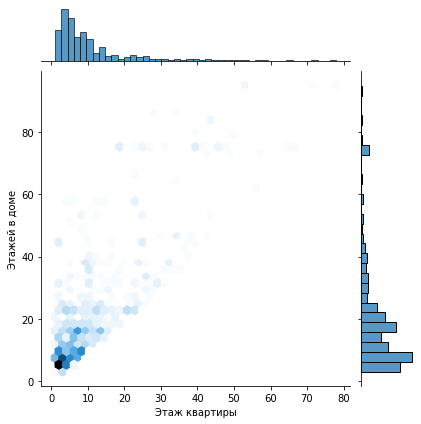

In [193]:
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable = True)

plot = df3['Год постройки'].iplot(kind = 'hist', xTitle = 'Год постройки', yTitle = 'Количество квартир', title = 'Распределение квартир по году постройки дома', )
plt.show()


plot = df3["Этаж квартиры"].iplot(kind = 'hist', xTitle = "Этаж квартиры", yTitle = 'Количество квартир', title = 'Распределение квартир по этажу')
plt.show()

plot = df3["Этажей в доме"].iplot(kind = 'hist', xTitle = "Этажей в доме", yTitle = 'Количество квартир', title = 'Распределение квартир по количеству этажей в доме')
plt.show()

sns_plot = sns.jointplot(x = 'Этаж квартиры', y = 'Этажей в доме', data = df3[['Этаж квартиры', 'Этажей в доме']], kind = 'hex')
plt.show()

Напрашивается гипотеза, что большинство квартир находится в пяти-девятиэтажных домах 2005-2009 гг. постройки, на втром или третьем этаже. Докажем её с помощью методов pandas.

In [194]:
from collections import Counter

year = Counter(df3['Год постройки']).most_common(1)[0][0]
print(str(year)+' - самый частый год постройки')

floorst = Counter(df3['Этажей в доме']).most_common(1)[0][0]
print(str(floorst)+' - самое частое количество этажей в доме')

floormx = Counter(df3['Этаж квартиры']).most_common(1)[0][0]
print(str(floormx)+' - самый частый этаж квартиры')

2008 - самый частый год постройки
9 - самое частое количество этажей в доме
3 - самый частый этаж квартиры


Таким образом, самое частое предложение - это квартира на третьем этаже девятиэтажного дома 2008 г. постройки.